In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

2024-11-07 12:09:04.106834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 12:09:06.814252: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-11-07 12:09:06.814379: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-11-07 12:09:06.822017: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
Dropped Escape call with ulEscapeCode : 0x03007703
Dropped Escape call with ulEscapeCode : 0x03007703
2024-11-07 12:09:10.077271: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


In [2]:
def plot_history(history):
    # Get the training and validation accuracy and loss from the history object
    acc = history.history['mae']
    val_acc = history.history['val_mae']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(14, 6))

    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    # Subplot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def cyclic_mean_squared_error(y_true, y_pred):
    # Convert y_true and y_pred to radians (scale 0 to 2*pi)
    y_true_rad = y_true * 2 * np.pi
    y_pred_rad = y_pred * 2 * np.pi
    
    # Calculate angular distance, taking cyclicity into account
    angle_diff = tf.math.floormod(y_pred_rad - y_true_rad + np.pi, 2 * np.pi) - np.pi
    
    # Mean squared error based on cyclic angular difference
    return tf.reduce_mean(tf.square(angle_diff))

def cyclic_mean_absolute_percentage_error(y_true, y_pred):
    y_true_rad = y_true * 2 * np.pi
    y_pred_rad = y_pred * 2 * np.pi
    angle_diff = tf.math.floormod(y_pred_rad - y_true_rad + np.pi, 2 * np.pi) - np.pi
    
    # Calculate percentage relative to the full cycle (2π)
    return tf.reduce_mean(tf.abs(angle_diff) / (2 * np.pi))


In [3]:
dataset = 'clock150' # 'clock75' or 'clock150'
if dataset == 'clock75':
    path = 'data/clock75'
    num_classes = 75
elif dataset == 'clock150':
    path = 'data/clock150'
    num_classes = 150

images = np.load(path+'/images.npy')
labels = np.load(path+'/labels.npy')

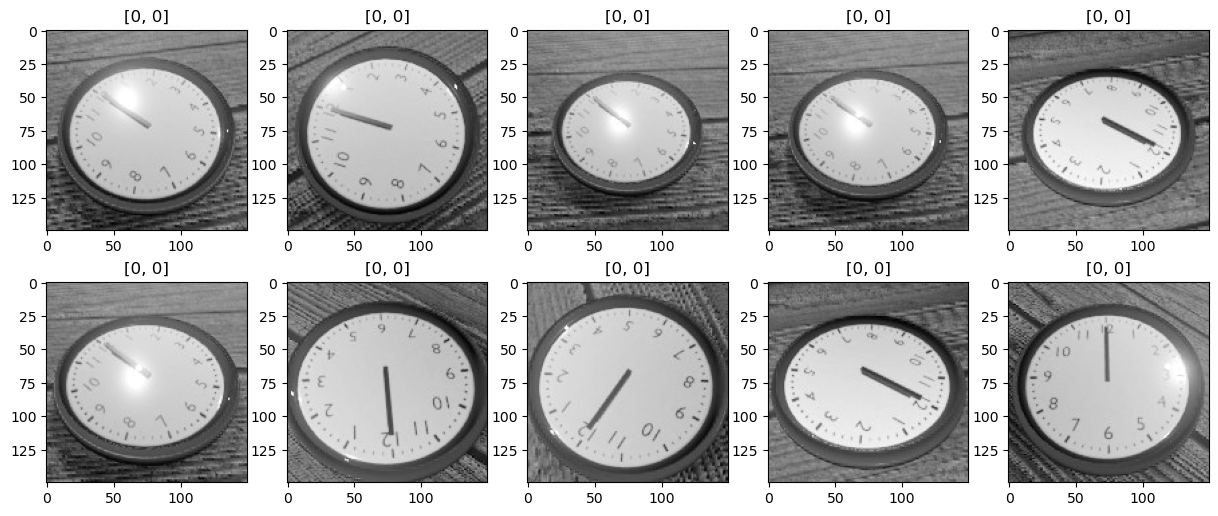

In [4]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    axs[i // 5, i % 5].imshow(images[i], cmap='gray')
    axs[i // 5, i % 5].set_title(list(labels[i]))
plt.show()

In [5]:
def class_to_num(labels):
    return labels[:, 0]+ labels[:, 1]/60

def num_to_class(numbers):
    hours = np.floor(numbers)
    minutes = (numbers - hours) * 60
    return np.stack([hours, minutes], axis=1)

def class_to_int(labels):
    return labels[:, 0]*60 + labels[:, 1]

def class_to_split_num(labels):
    min_hand = labels[:, 1]/60
    hour_hand = labels[:, 0]/12 + min_hand/12 #to account for the fact that the hour hand moves as the minute hand moves
    return np.array([hour_hand, min_hand]).T

def class_to_cos_sin(labels):
    min_sin = np.sin(labels[:, 1]/30*np.pi)
    min_cos = np.cos(labels[:, 1]/30*np.pi)
    hour_sin = np.sin((labels[:, 0]/12 + labels[:,1]/720)*2*np.pi)
    hour_cos = np.cos((labels[:, 0]/12 + labels[:,1]/720)*2*np.pi)
    return np.array([hour_cos, hour_sin, min_cos, min_sin]).T

def cos_sin_to_time(cos_sin):
    hour = np.arctan2(cos_sin[:, 1], cos_sin[:, 0])/(2*np.pi)*12
    hour = (hour + 12) % 12
    minute = np.arctan2(cos_sin[:, 3], cos_sin[:, 2])/(2*np.pi)*60
    minute = (minute + 60) % 60
    return np.array([hour, minute]).T

#convert labels for regression
labels_num = class_to_split_num(labels)
labels_cos_sin = class_to_cos_sin(labels)

In [6]:
#shuffle data
np.random.seed(42)
idx = np.random.permutation(len(images))
images = images[idx]
labels = labels[idx]
labels_num = labels_num[idx]
labels_cos_sin = labels_cos_sin[idx]

#split data
split = int(0.8 * len(images))
x_train, x_test = images[:split], images[split:]
y_train_og, y_test_og = labels[:split], labels[split:]
y_train_num, y_test_num = labels_num[:split], labels_num[split:]
y_train_cos_sin, y_test_cos_sin = labels_cos_sin[:split], labels_cos_sin[split:]

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

img_rows, img_cols = images.shape[1], images.shape[2]
batch_size = 128
# num_classes = 720//5

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = y_train_cos_sin
y_test = y_test_cos_sin
print('y_train shape:', y_train.shape)

x_train shape: (14400, 150, 150, 1)
14400 train samples
3600 test samples
y_train shape: (14400, 4)


In [ ]:
#create model
base_nodes = 64
model = Sequential()
model.add(Conv2D(base_nodes, kernel_size=(5, 5), activation='relu', input_shape=input_shape,
                 kernel_regularizer=keras.regularizers.l2(0.0001),
                 bias_regularizer=keras.regularizers.l2(0.0001),
                 activity_regularizer=keras.regularizers.l2(0.0001)))
model.add(BatchNormalization())
if input_shape[0] == 75:
    model.add(MaxPooling2D(pool_size=(2, 2)))
else:
    model.add(MaxPooling2D(pool_size=(3, 3))) #increased pool size for 150x150 images to reduce memory usage
model.add(Dropout(0.1))


model.add(Conv2D(2*base_nodes, kernel_size=(3, 3), activation='relu',
                 kernel_regularizer=keras.regularizers.l2(0.0001),
                 bias_regularizer=keras.regularizers.l2(0.0001),
                 activity_regularizer=keras.regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Conv2D(4*base_nodes, kernel_size=(3, 3), activation='relu',
                 kernel_regularizer=keras.regularizers.l2(0.0001),
                 bias_regularizer=keras.regularizers.l2(0.0001),
                 activity_regularizer=keras.regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(GlobalAveragePooling2D())

model.add(Dropout(0.3))
if input_shape[0] == 75:
    model.add(Dense(128, activation='relu'))
else:
    model.add(Dense(256, activation='relu')) #increased number of nodes for 150x150 images
model.add(Dropout(0.5))

model.add(Dense(4, activation='linear')) #4 outputs for hours and minutes cos and sin

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae'])

print(model.summary())

2024-11-07 12:09:14.649866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 12:09:14.652113: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (AMD Radeon RX 6650 XT)
Dropped Escape call with ulEscapeCode : 0x03007703
2024-11-07 12:09:17.535959: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-07 12:09:17.536190: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2024-11-07 12:09:17.536532: I tensorflow/core/c

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 64)      1664      
                                                                 
 batch_normalization (BatchN  (None, 146, 146, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 128)      5

In [9]:
epochs=300
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.125,
                    callbacks=[reduce_lr, early_stop])

score = model.evaluate(x_test, y_test, verbose=0)

2024-11-07 12:09:18.080627: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1134000000 exceeds 10% of free system memory.
2024-11-07 12:09:21.948440: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1134000000 exceeds 10% of free system memory.


Epoch 1/300


2024-11-07 12:09:25.160681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-07 12:09:25.313111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-07 12:09:25.313291: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13943 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-07 12:09:25.336236: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-07 12:09:25.336325: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

99/99 [==============================] - ETA: 0s - loss: 0.8607 - mae: 0.6562

2024-11-07 12:09:43.770435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-07 12:09:43.827448: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-07 12:09:43.827603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13943 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-07 12:09:43.837976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-07 12:09:43.838041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

99/99 [==============================] - 20s 167ms/step - loss: 0.8607 - mae: 0.6562 - val_loss: 0.5266 - val_mae: 0.6369 - lr: 0.0010
Epoch 2/300
99/99 [==============================] - 17s 174ms/step - loss: 0.5315 - mae: 0.6366 - val_loss: 0.5259 - val_mae: 0.6370 - lr: 0.0010
Epoch 3/300
99/99 [==============================] - 16s 162ms/step - loss: 0.5163 - mae: 0.6278 - val_loss: 0.5291 - val_mae: 0.6382 - lr: 0.0010
Epoch 4/300
99/99 [==============================] - 17s 169ms/step - loss: 0.5020 - mae: 0.6141 - val_loss: 0.5472 - val_mae: 0.6433 - lr: 0.0010
Epoch 5/300
99/99 [==============================] - 16s 162ms/step - loss: 0.4947 - mae: 0.6079 - val_loss: 0.5587 - val_mae: 0.6469 - lr: 0.0010
Epoch 6/300
99/99 [==============================] - 17s 169ms/step - loss: 0.4879 - mae: 0.6026 - val_loss: 0.5693 - val_mae: 0.6496 - lr: 0.0010
Epoch 7/300
99/99 [==============================] - 16s 162ms/step - loss: 0.4846 - mae: 0.6001 - val_loss: 0.5804 - val_mae: 0.6

2024-11-07 12:55:05.721486: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 324000000 exceeds 10% of free system memory.
2024-11-07 12:55:09.732264: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 324000000 exceeds 10% of free system memory.


In [10]:
print(score)

[0.05189741775393486, 0.15036450326442719]


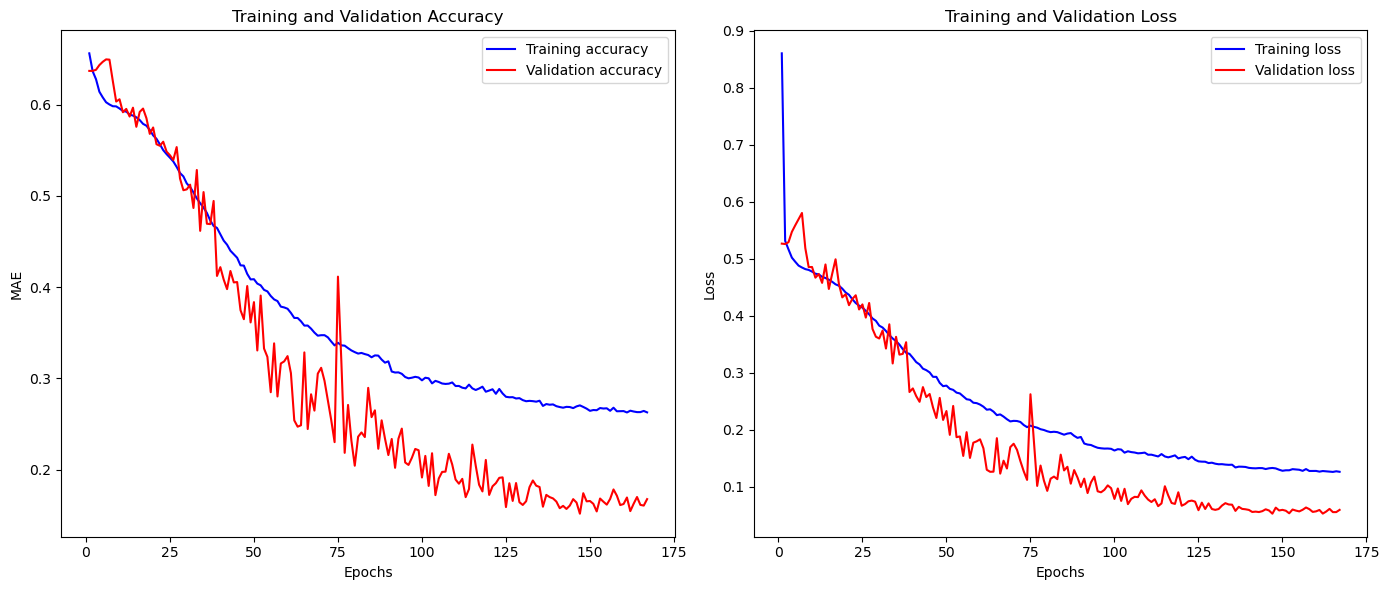

In [11]:
plot_history(history)

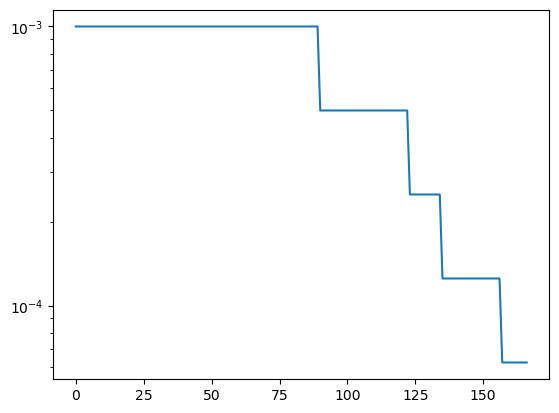

In [12]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')
plt.show()

2024-11-07 12:55:13.028690: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 324000000 exceeds 10% of free system memory.


 19/113 [====>.........................] - ETA: 0s

2024-11-07 12:55:14.239209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - 2s 9ms/step


2024-11-07 12:55:15.251638: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-07 12:55:15.251723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13943 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-07 12:55:15.287923: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-07 12:55:15.287977: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13943 MB memory) -> physical PluggableDevice (device: 0, name: 

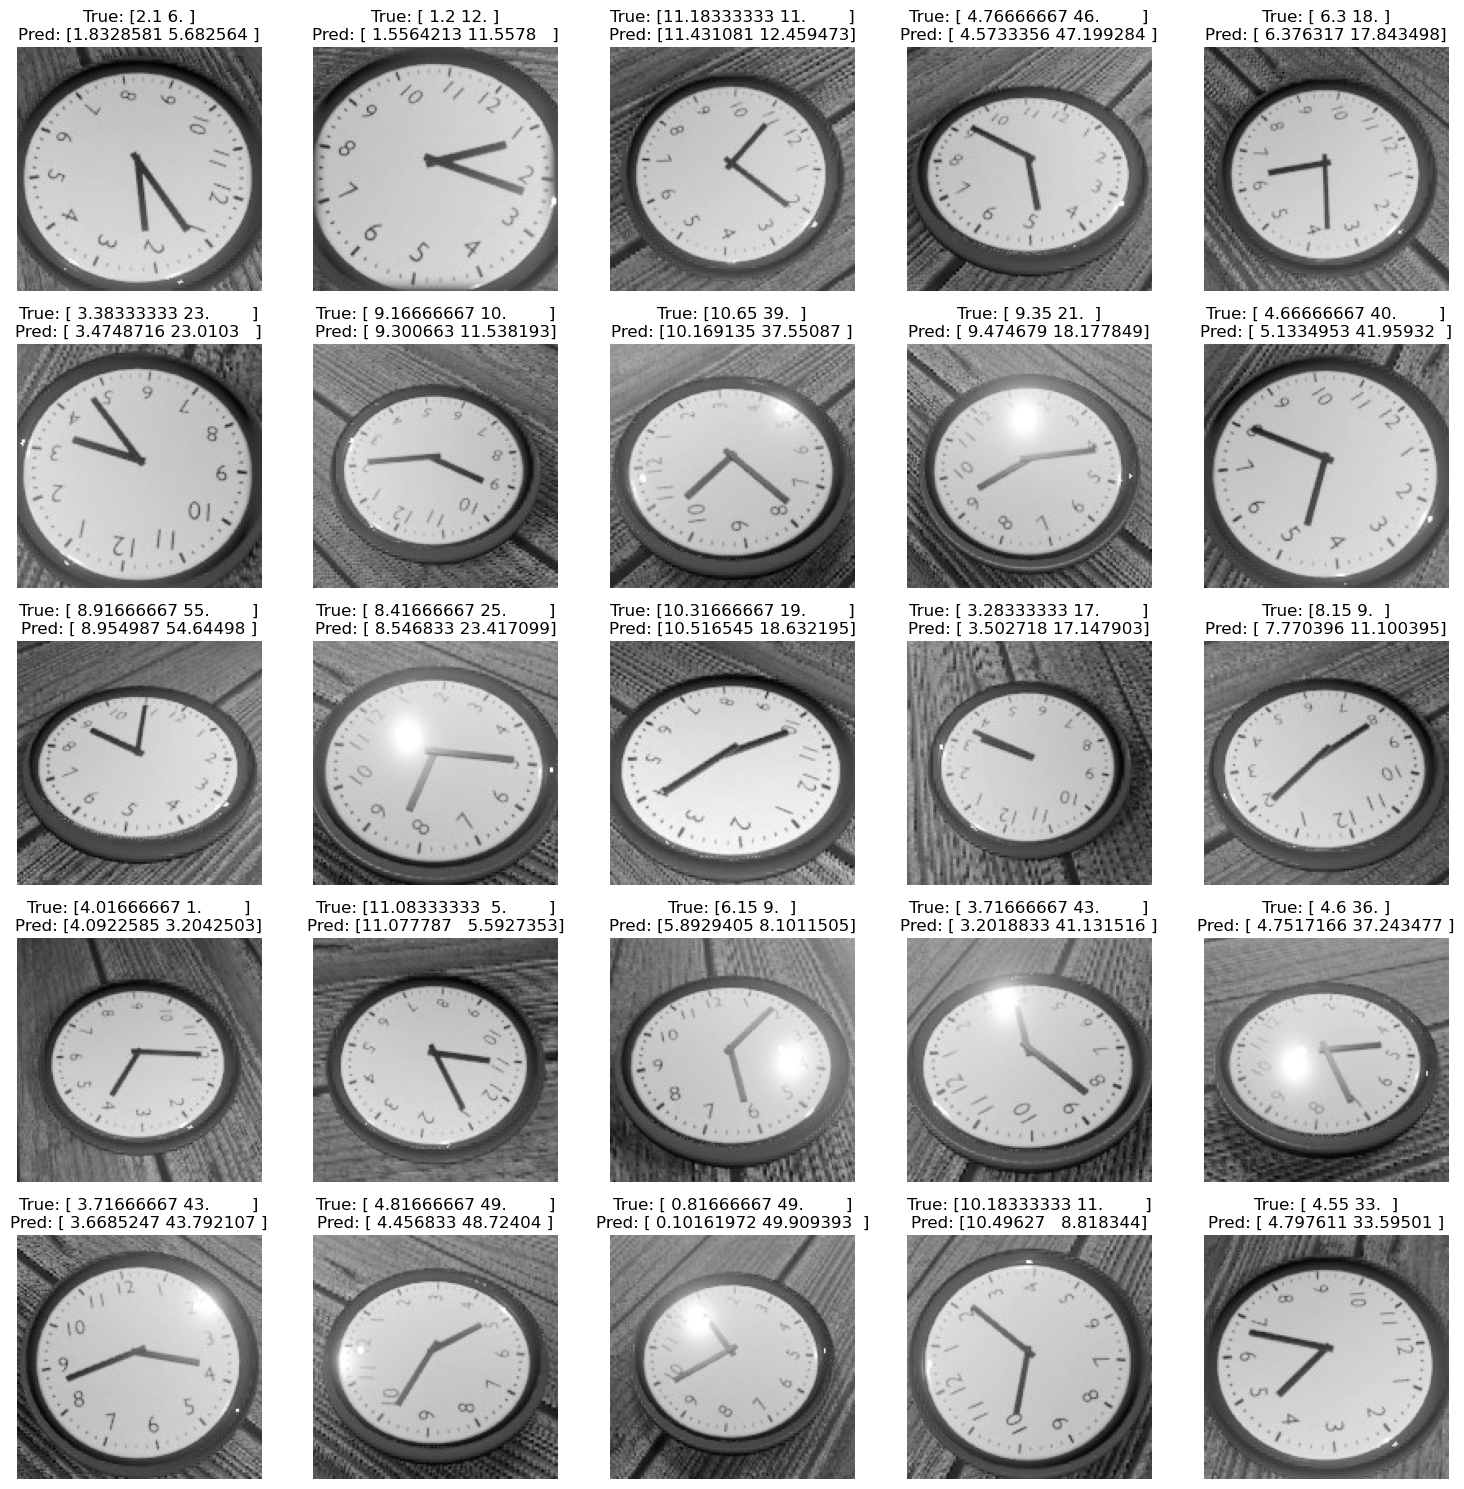

In [13]:
# Predict the classes for the test set
predictions = model.predict(x_test)

# Convert predictions from one-hot encoding to class labels
predicted_classes = cos_sin_to_time(predictions)
true_classes = cos_sin_to_time(y_test)

# Function to plot images and their predicted & true labels
def plot_images(images, true_labels, predicted_labels, num_images):
    # Define max images per row
    max_images_per_row = 5
    # Calculate the number of rows needed
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row

    # Create a figure with subplots
    plt.figure(figsize=(15, 3 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, max_images_per_row, i + 1)  # num_rows rows, max_images_per_row columns
        plt.imshow(images[i].reshape(img_rows, img_cols), cmap='gray')
        plt.title(f'True: {true_labels[i]}\nPred: {predicted_labels[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot the specified number of images from the test set
plot_images(x_test, true_classes, predicted_classes, num_images=25)

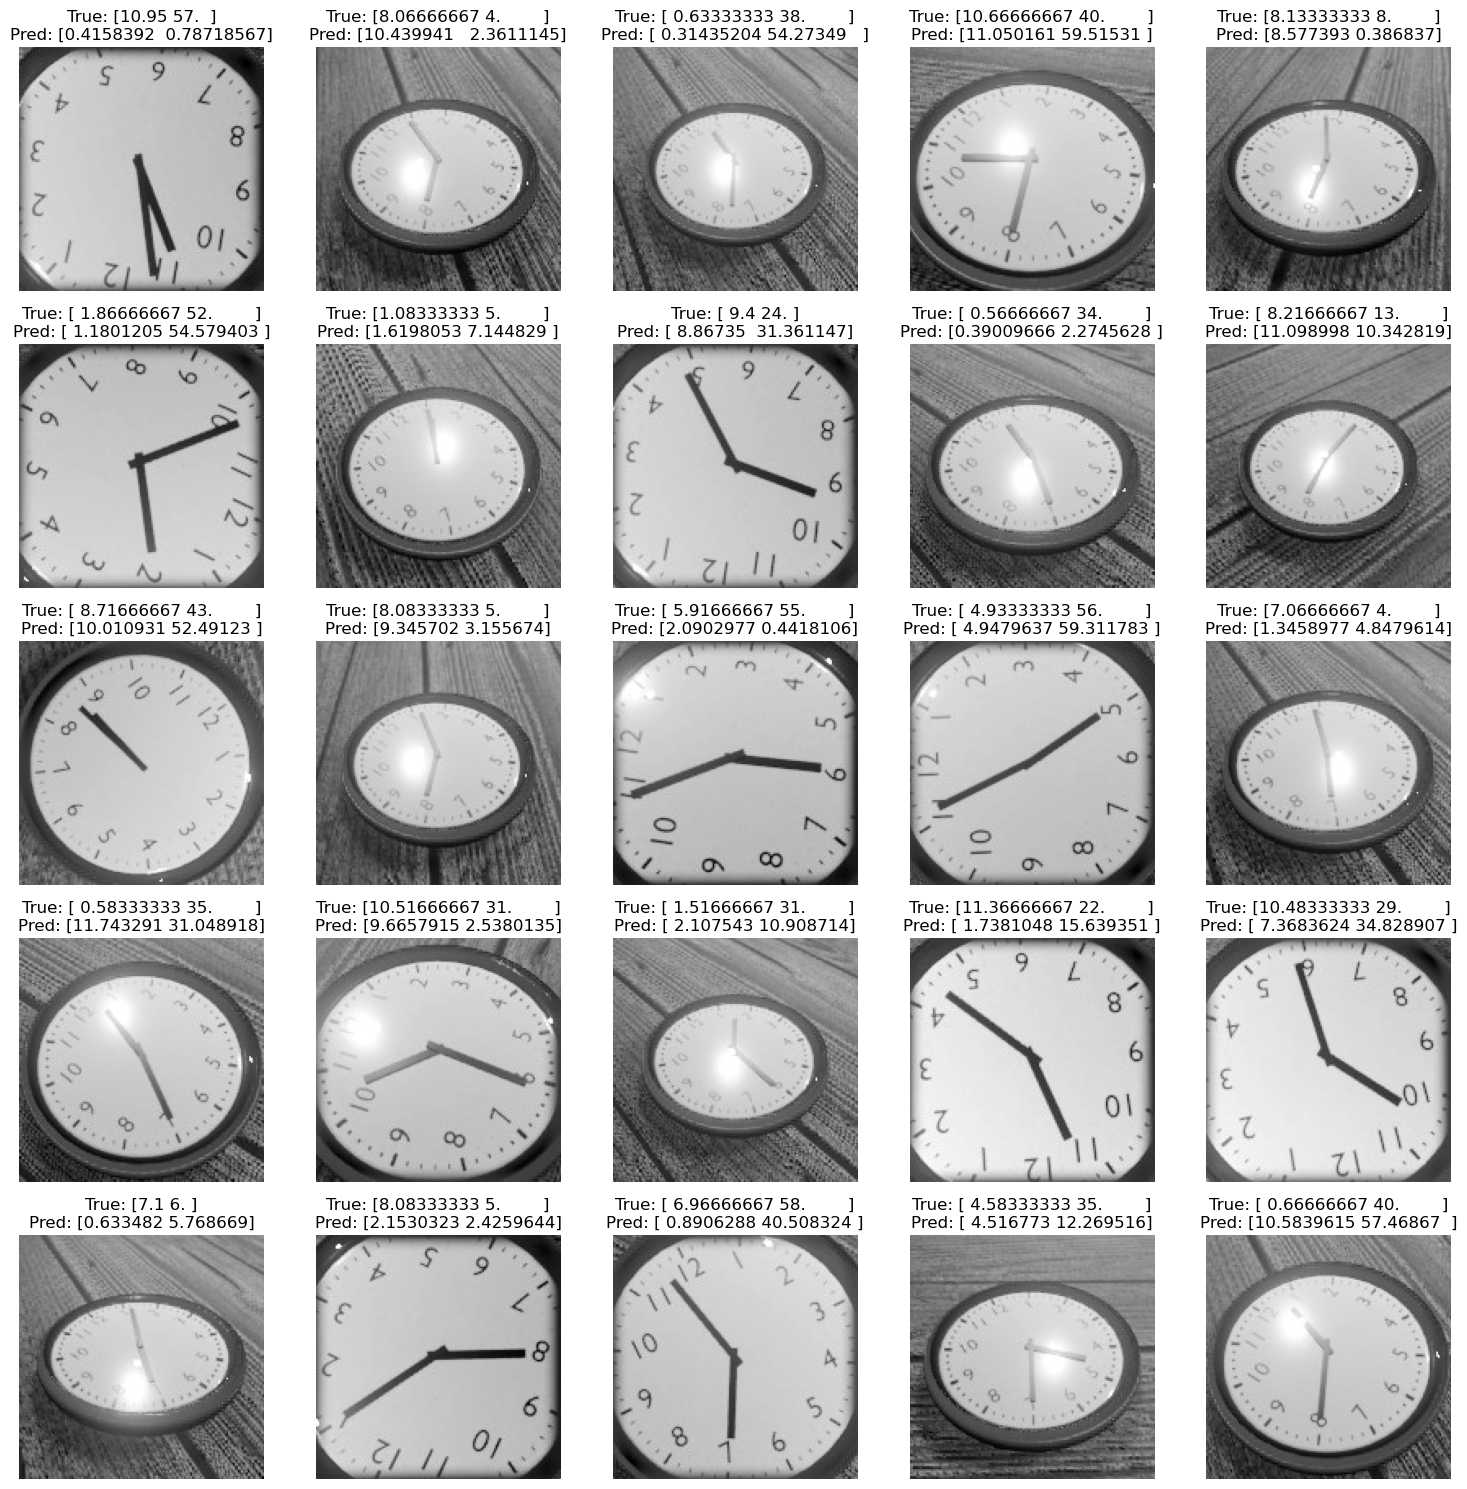

In [14]:
#plot the images with the highest error
errors = np.abs(predictions - y_test)
error = np.sum(errors, axis=1)
idx = np.argsort(error)[-25:]
plot_images(x_test[idx], true_classes[idx], predicted_classes[idx], num_images=25)\
#the model seems to struggle with clocks that are either very zoomed in or are at an angle

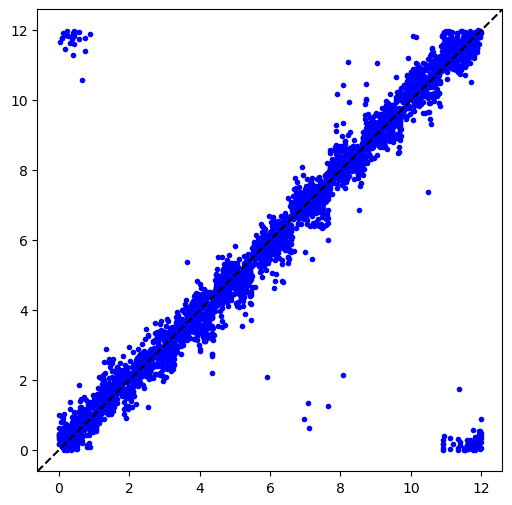

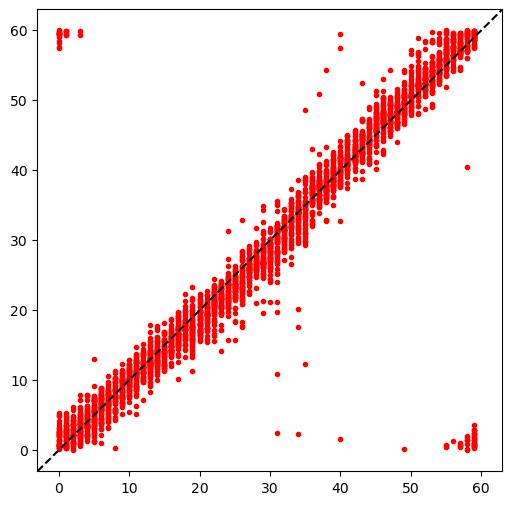

In [15]:
plt.figure(figsize=(6,6))
plt.scatter(true_classes[:, 0], predicted_classes[:, 0], label='Hours', color='blue', marker='.') 
plt.axline([0, 0], [12, 12], color='black', linestyle='--')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(true_classes[:, 1], predicted_classes[:, 1], label='Minutes', color='red', marker='.')
plt.axline([0, 0], [60, 60], color='black', linestyle='--')
plt.show()

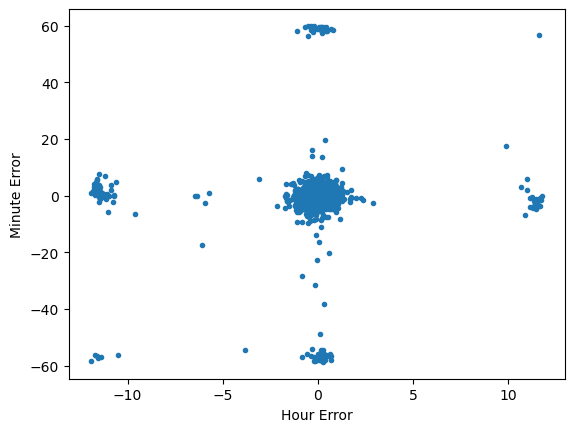

In [16]:
plt.scatter(predicted_classes[:, 0]-true_classes[:, 0], predicted_classes[:, 1]-true_classes[:, 1], marker='.')
plt.xlabel('Hour Error')
plt.ylabel('Minute Error')
plt.show()

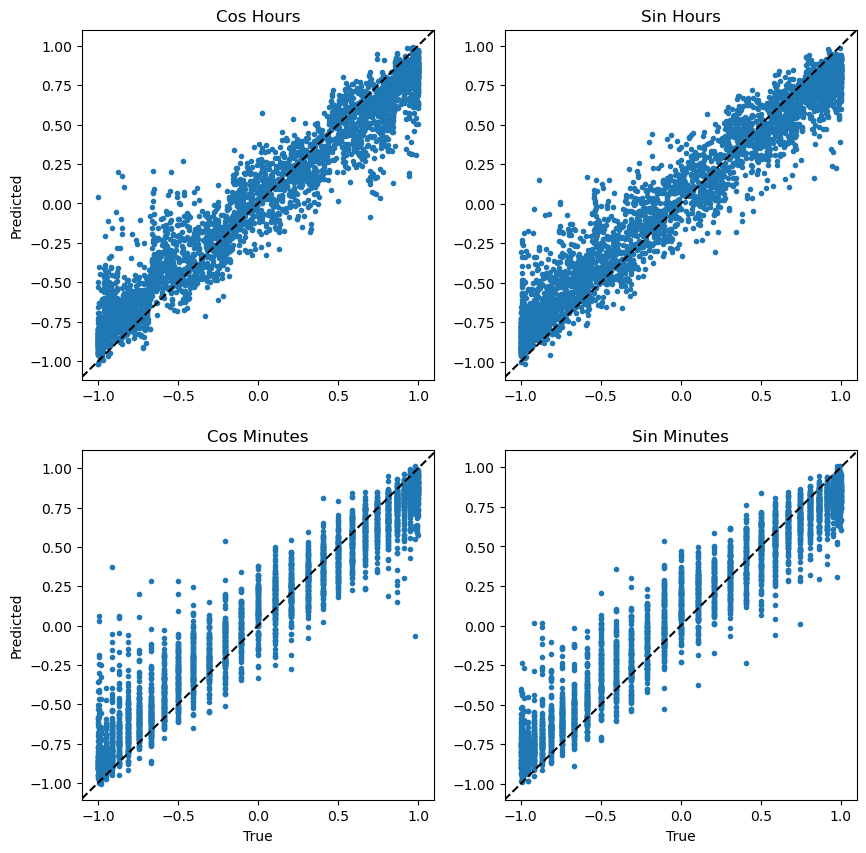

In [17]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs[0,0].scatter(y_test[:, 0], predictions[:, 0], marker='.')
axs[0,0].set_ylabel('Predicted')
axs[0,0].set_title('Cos Hours')

axs[0,1].scatter(y_test[:, 1], predictions[:, 1], marker='.')
axs[0,1].set_title('Sin Hours') 

axs[1,0].scatter(y_test[:, 2], predictions[:, 2], marker='.')
axs[1,0].set_xlabel('True')
axs[1,0].set_ylabel('Predicted')
axs[1,0].set_title('Cos Minutes')

axs[1,1].scatter(y_test[:, 3], predictions[:, 3], marker='.')
axs[1,1].set_xlabel('True')
axs[1,1].set_title('Sin Minutes')

for ax in axs.flat:
    ax.axline([-1, -1], [1, 1], color='black', linestyle='--')
plt.show()

